In [1]:
%matplotlib inline

In [3]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5


In [4]:
os.chdir('AnomaliesRecycling')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling



Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from src.transfer_learning import TransferLearningTrainer
from src.cam import CAM


plt.ion()   # interactive mode

In [5]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

Load Data and Data Augmentation
---------

In [6]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),

        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
transferLearningTrainer = TransferLearningTrainer(data_transforms=data_transforms)

Visualize a few images



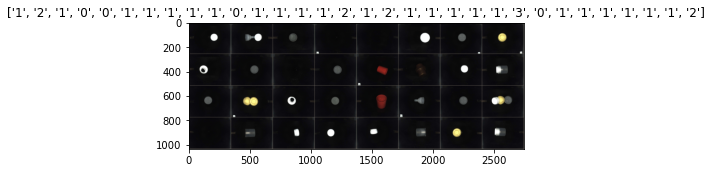

In [8]:
# Get a batch of training data
inputs, classes = next(iter(transferLearningTrainer.dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
transferLearningTrainer.imshow(out, [transferLearningTrainer.class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [9]:
model_name = "ResNet18_test"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, 6)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

 ***Train and evaluate***

In [10]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=5,
                                               model_name=model_name,
                                               early_stop=True)

Epoch 0/4
----------
train Loss: 0.6530 Acc: 0.7800
test Loss: 0.5691 Acc: 0.7514
trigger times: 0

Epoch 1/4
----------
train Loss: 0.3084 Acc: 0.8986
test Loss: 0.3590 Acc: 0.8730
Trigger Times: 1

Epoch 2/4
----------
train Loss: 0.2451 Acc: 0.9127
test Loss: 0.5141 Acc: 0.7459
Trigger Times: 2

Epoch 3/4
----------
train Loss: 0.1958 Acc: 0.9345
test Loss: 0.2843 Acc: 0.9074
Trigger Times: 3

Epoch 4/4
----------
train Loss: 0.1672 Acc: 0.9427
test Loss: 0.3615 Acc: 0.8711
Trigger Times: 4

Training complete in 1m 7s
Best test acc: 0.907441


/cvhci/temp/p22g5/data/test/3/Anlerndaten (686).jpg


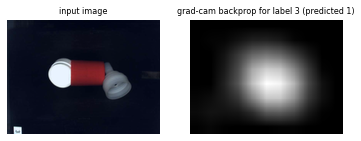

In [12]:
model_name = "ResNet18_test.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = torch.nn.Linear(num_ftrs, 6)
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR + model_name))
# print(model_ft)

cam = CAM(transferLearningTrainer)
cam.print_cam(model_ft)

In [13]:
!reload_ext tensorboard
!tensorboard --logdir /cvhci/temp/p22g5/runs/

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: reload_ext: command not found
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [16]:
model_name = "ResNet18_test.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR+model_name))
#visualize_model(model_ft, dataloaders, class_names)

<All keys matched successfully>

***Filenames where validation failed***

In [18]:
transferLearningTrainer.print_misclassified(model_ft)

('/cvhci/temp/p22g5/data/test/0/trial (1533).jpg', 0)
must be 0, but predicted 1
('/cvhci/temp/p22g5/data/test/0/trial (18).jpg', 0)
must be 0, but predicted 1
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (113).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (14).jpg', 1)
must be 1, but predicted 3
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (295).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (667).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (753).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (777).jpg', 1)
must be 1, but predicted 0
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (799).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (804).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (879).jpg', 1)
must be 1, but predicted 2
('/cvhci/temp/p22g5/data/test/1/Anlerndaten (931).jpg', 1)
must be 

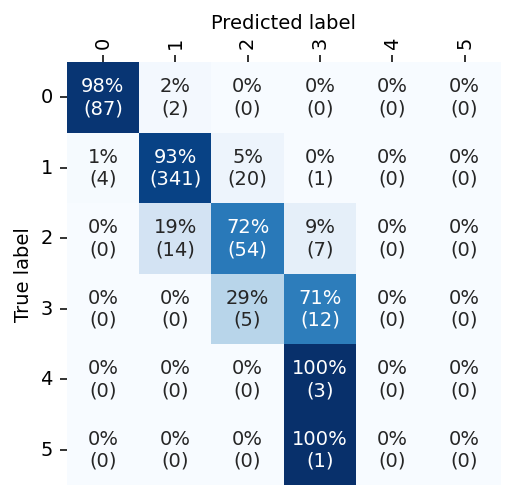

In [19]:
transferLearningTrainer.print_confusion_matrix(model_ft)

ConvNet as fixed feature extractor
----------------------------------

In [79]:
model_name = "ResNet18_test"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [81]:
model_conv = transferLearningTrainer.train_model(model_conv,
                                                 criterion,
                                                 optimizer_conv,
                                                 exp_lr_scheduler,
                                                 num_epochs=50,
                                                 model_name=model_name)

Epoch 0/49
----------
train Loss: 0.8307 Acc: 0.6977
test Loss: 0.5755 Acc: 0.7786

Epoch 1/49
----------
train Loss: 0.7038 Acc: 0.7482
test Loss: 0.8494 Acc: 0.6987

Epoch 2/49
----------
train Loss: 0.6470 Acc: 0.7691
test Loss: 0.4865 Acc: 0.8221

Epoch 3/49
----------
train Loss: 0.5775 Acc: 0.7886
test Loss: 0.4508 Acc: 0.8530

Epoch 4/49
----------
train Loss: 0.5704 Acc: 0.7818
test Loss: 0.6314 Acc: 0.7387

Epoch 5/49
----------
train Loss: 0.5340 Acc: 0.7982
test Loss: 0.4207 Acc: 0.8603

Epoch 6/49
----------
train Loss: 0.5195 Acc: 0.8041
test Loss: 0.4809 Acc: 0.8566

Epoch 7/49
----------
train Loss: 0.4549 Acc: 0.8300
test Loss: 0.4015 Acc: 0.8584

Epoch 8/49
----------
train Loss: 0.4685 Acc: 0.8314
test Loss: 0.3961 Acc: 0.8566

Epoch 9/49
----------
train Loss: 0.4585 Acc: 0.8350
test Loss: 0.4070 Acc: 0.8512

Epoch 10/49
----------
train Loss: 0.4460 Acc: 0.8364
test Loss: 0.4058 Acc: 0.8566

Epoch 11/49
----------
train Loss: 0.4324 Acc: 0.8482
test Loss: 0.3950 Acc

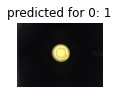

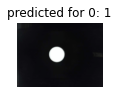

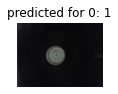

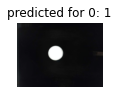

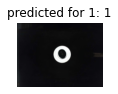

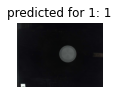

In [82]:
transferLearningTrainer.visualize_model(model_conv)